<font face="Times New Roman" size="3">
<hr style="width:100%;height:2px;color:black">
<div style="width:100%">
    <div style="float:left;width:50%">Albert-Ludwigs-Universität Freiburg</div>
    <div style="float:left;width:50%;text-align:right">Wintersemester 2022/23</div> 
</div>
<div style="clear:both;text-align:center">
    <h1 style="margin-top:20px;padding:0px">Datenanalyse für Naturwissenschaftler*Innen</h1>
    <h2 style="margin:5px;padding:0px">Statistische Methoden in Theorie und Praxis</h2>
    Vorlesung: Dr. Andrea Knue<br />
    Übungsleitung: Dr. Constantin Heidegger<br />
    <h1 style="margin:10px;padding:0px">Musterlösung 10</h1>
    Ausgabe: 13. Januar 2023 10:00 Uhr, Abgabe: 20. Januar 2023 bis 10:00 Uhr via Ilias
</div>
<hr style="font-family:width:100%;height:2px;color:black">
</font>

<font face="Times New Roman" size=3>
    <h3 style="margin:0px">Aufgabe 3: Monte-Carlo Methode zur Ermittlung von Bias und
Varianz (12P)</h3>
</font>

Oft können Bias und Varianz einer Anpassungsmethode nicht analytisch bestimmt werden. Deswegen muss man auf die Monte-Carlo-Methode zurückgreifen, um eine Aussage über diese beiden Grössen treffen zu können.
Dabei gibt es verschiedene Möglichkeiten, eine Anpassung mit Histogrammen durchzuführen, z.B.:
   * Erweiterte gebinnte Maximum-Likelihood Anpassung (Extended binned maximum likelihood)
   * Gebinnte Anpassung mit der Methode der kleinsten Quadrate (Binned least square method)
   
Im folgenden sollen der Bias und die Varianz dieser beiden Anpassungsmethoden zur Ermittlung des Zerfallsparameters einer Exponentialfunktion untersucht und verglichen werden.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.stats as stat
import math

In [2]:
## von Übungsblatt 5:
def listOfBins(xmin, xmax, nbins):
    return [xmin+(xmax-xmin)/nbins*i for i in range(nbins+1)] ## +1 since we need the upper bound as well

In [3]:
# von Übungsblatt 8:
def createData(l, n):
    return np.random.exponential(1/l, n)

<font face="Times New Roman" size=4>
a) Erzeugung und Darstellung der Pseudo-Daten (1P)
</font>

Zuerst müssen wir so wie in den vorangegangenen Übungsblättern wieder die Pseudo-Daten erzeugen. Erstellen Sie also eine Liste von exponentialverteilten Zufallszahlen mit einer Stichprobengröße von 1000 und $\lambda=1/2$. Stellen Sie die Verteilung graphisch in einem `matplotlib` Histogramm dar, und lassen Sie sich die Binhöhen und -grenzen zurückgeben. Verwenden Sie den Seed 8743 um Ihre Ergebnisse reproduzierbar zu machen.

In [4]:
# passe createData an um auch den Seed zu verwenden
def createData(l, n, seed):
    np.random.seed(seed)
    return np.random.exponential(1/l, n)

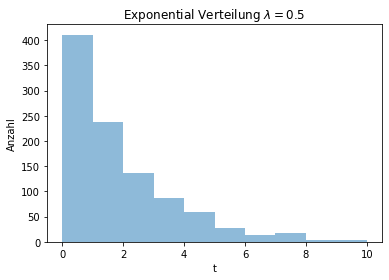

In [5]:
lamb = 0.5
b = listOfBins(0,10,10)

def plotHistExpData(l, n=1000, seed=8743, plot=False):
    data = createData(l, n, seed)
    bins = listOfBins(0,10,10)
    # bins can be given as a string, 
    # it is one of the binning strategies supported
    # by numpy.histogram_bin_edges: 
    # 'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
    # plt.hist(data, bins="fd", density=False, alpha=0.5)
    
    h, bins, patches = plt.hist(data, bins=bins, 
                                density=False, alpha=0.5)
    if plot:
        plt.xlabel('t')
        plt.ylabel('Anzahl')
        plt.title(f'Exponential Verteilung $\lambda={l}$')
        plt.show()
    return data, h, bins

data, bin_height, bins = plotHistExpData(lamb, plot=True)


<font face="Times New Roman" size=4>
b) Gebinnte Maximum-Likelihood Schätzung (2P)
</font>

Führen Sie als erste Abschätzung von $\hat{\lambda}$ die Maximum-Likelihood Methode für das Histogramm durch. Siehe Übungsblatt 9.

In [6]:
bin_width = bins[1] - bins[0] # Binbreite
bin_middle = bins[:-1] + bin_width/2 #Binmitte


In [7]:
def expFunc(x, lamb, bin_height):
    bin_width = x[1] - x[0]
    hist_integral = np.sum(bin_height) * bin_width
    return hist_integral * lamb * np.exp(-lamb*x)


def negloglik_binned(lamb, bin_middle, bin_height):
    return -np.sum(bin_height * np.log(\
            expFunc(bin_middle, lamb, bin_height)))


In [8]:
print(negloglik_binned(lamb, bin_middle, bin_height))


-5237.718778633688


In [9]:
nll_result = opt.minimize(negloglik_binned, # die zu minimierende Funktion
                        x0 = (0.3),          # Startwert für lambda
                        args = (bin_middle, 
                                bin_height),
                        )
print(nll_result)


      fun: -5238.618129217611
 hess_inv: array([[0.00028093]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 7
     njev: 15
   status: 0
  success: True
        x: array([0.52185292])


In [10]:
print(f"neg log likelihood lambda hat = {nll_result.x}")

neg log likelihood lambda hat = [0.52185292]


<font face="Times New Roman" size=4>
c) Gebinnte Schätzung mit der Methode der kleinsten Quadrate (5P)
</font>

Nun wollen wir die Methode der kleinsten Quadrate durchführen, um eine Abschätzung für $\lambda$ zu bekommen. Verwenden Sie dazu die Funktion `least_squares` von `scipy.optimize` und füttern Sie sie mit der Differenz zwischen Binhöhen (am Binmittelpunkt in $x$ Richtung) und Funktionswert der Exponentialverteilung.

In [11]:
def residual(lamb, x, bin_height):
      return bin_height - expFunc(x, lamb, bin_height)

In [12]:


ls_result = opt.least_squares(residual,    # Funktion
                                x0 = (0.3), # Startwert für lambda
                                args = (bin_middle, 
                                        bin_height),
                            )
print(ls_result)

 active_mask: array([0.])
        cost: 123.7674370378242
         fun: array([ 3.55597989, -1.95105558, -3.13607795,  3.81530199, 11.80167244,
       -0.266561  , -2.57730695,  7.27801416, -2.70159007,  0.6562254 ])
        grad: array([-0.00028231])
         jac: array([[-559.78961945],
       [ -89.34513474],
       [  87.73841286],
       [ 133.64007664],
       [ 126.57335567],
       [ 102.49721599],
       [  76.6881845 ],
       [  54.69680786],
       [  37.7792722 ],
       [  25.49993938]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 6
        njev: 6
  optimality: 0.00028231274202639156
      status: 2
     success: True
           x: array([0.53364481])


In [13]:
print(f"least squares lambda hat = {ls_result.x}")

least squares lambda hat = [0.53364481]


Alternativ können wir auch die Funktion `curve_fit` verwenden, und sie direkt mit der Funktion `expFunc` und den $x$- und $y$-Werten der Bins füttern. Allerdings müssen wir den Parameter `full_output` auf `True` setzen, damit der ganze Output angezeigt wird. Der Fehler auf dem Parameter kann dann mittels `np.sqrt(np.diag(result[1]))` berechnet werden.

In [14]:
fitfunc = lambda x, lamb: expFunc(x, lamb, bin_height)
result = opt.curve_fit(fitfunc,            # Funktion
                       bin_middle,                 # x Daten
                       bin_height,                 # y Daten
                       #p0 = (0.3),         # Startwert für lambda
                       full_output = True, # wir wollen den ganzen Output sehen
                      )

In [15]:
print(result)

(array([0.5336448]), array([[7.15533934e-05]]), {'fvec': array([ -3.55598392,   1.95105493,   3.13607858,  -3.81530102,
       -11.80167153,   0.26656173,   2.57730751,  -7.27801376,
         2.70159034,  -0.65622522]), 'nfev': 11, 'fjac': array([[-6.19985917e+02,  1.44109694e-01, -1.41516052e-01,
        -2.15553281e-01, -2.04155490e-01, -1.65322307e-01,
        -1.23693935e-01, -8.82231277e-02, -6.09360855e-02,
        -4.11301795e-02]]), 'ipvt': array([1], dtype=int32), 'qtf': array([0.00064736])}, 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000', 1)


In [16]:
curve_fit_error = np.sqrt(np.diag(result[1]))
print(f"curve fit lambda hat : {result[0]} +- {curve_fit_error}")

curve fit lambda hat : [0.5336448] +- [0.00845892]


Eine vierte und letzte Methode den Parameter $\lambda$ abzuschätzen ist via der `leastsq` Funktion, die den Levenberg-Marquadt Algorithmus verwendet. Implementieren Sie diese auch und lassen Sie sich den Output anzeigen. Der Fehler kann wieder so wie bei `curve_fit` berechnet werden.

In [17]:
lm_result = opt.leastsq(residual,    # Funktion
                        x0 = (0.3),          # Startwert für lambda
                        args = (bin_middle, 
                                bin_height),
                        )

## by now the Levenberg Marquart Algrorithm is 
# implemented in least_squares
lmls_result = opt.least_squares(residual,    # Funktion
                                x0 = (0.3), # Startwert für lambda
                                args = (bin_middle, 
                                        bin_height),
                                method='lm'
                                )

In [18]:
print("using the Levenberg Marquart Algrorithm")
print(f"least squares lambda hat = {ls_result.x}")

using the Levenberg Marquart Algrorithm
least squares lambda hat = [0.53364481]


<font face="Times New Roman" size=4>
d) Vergleich der Methoden (4P)
</font>

Wir wollen nun die Maximum-Likelihood Methode und die Methode der kleinsten Quadrate vergleichen und führen sie dazu beide 500 Mal aus. Erstellen Sie also einen `for` Loop anhand dessen die Schätzwerte der beiden Methoden generiert und in eine Liste `lst_est_ml` (Maximum-Likelihood) bzw. `lst_est_kq` (kleinste Quadrate) befüllt werden. Überprüfen Sie in jedem Durchlauf, ob die Fits erfolgreich waren; falls nicht, gehen Sie weiter zur nächsten Iteration. Verändern Sie in jeder Iteration den Wert des `seed` Parameters in der `createData` Funktion, um nicht jedes Mal die gleiche Verteilung zu erzeugen. Hierzu können Sie eine ganzzahlige Zufallszahl zwischen 0 und 100000 mit der Funktion `randint` im Paket `numpy.random` erzeugen.

In [19]:
n = 500

In [20]:
lst_est_ml = []
lst_est_kq = []
for i in range(n):
    seed = np.random.randint(0, 1000000)
    data, bin_height, bins = plotHistExpData(lamb, n=1000, 
                                            seed=seed)
    plt.clf() #clear the current figure
    bin_width = bins[1] - bins[0] # Binbreite
    bin_middle = bins[:-1] + bin_width/2 #Binmitte
    try:
        nll_result = opt.minimize(negloglik_binned, 
                                    x0 = (0.3),     
                                    args = (bin_middle, 
                                            bin_height),
        )
        lst_est_ml.append(nll_result.x[0])
    except:
        print("Fit %d was not successful! Skipping..."%i)
        pass
    try:
        ls_result = opt.least_squares(residual, 
                                        x0 = (0.3),
                                        args = (bin_middle, 
                                                bin_height),
        )  
        lst_est_kq.append(ls_result.x[0]) 
    except:
        print("Fit %d was not successful! Skipping..."%i)
        pass
    
    

<Figure size 432x288 with 0 Axes>

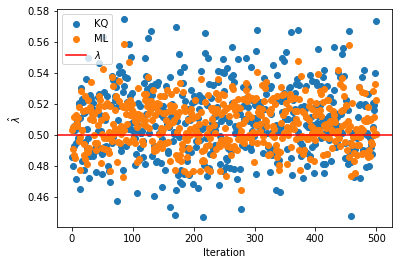

In [21]:
## lets check how random the random numbers are
x = np.linspace(0, n, n)
plt.scatter(x, lst_est_kq, label='KQ')
plt.scatter(x, lst_est_ml, label='ML')
plt.axhline(0.5, 0, 1, c='r', label=r'$\lambda$')
plt.xlabel('Iteration')
plt.ylabel("$\hat{\lambda}$")
plt.legend()

Erzeugen Sie nun zwei Histogramme, jeweils eins für die Schätzwerte der beiden Methoden, und stellen Sie beide in der gleichen Abbildung dar. Wählen Sie vernünftige Histogrammgrenzen für die $x$ Achse, und fügen Sie Achsenbezeichnungen hinzu. Vergessen Sie nicht die Bezeichnungen hinzuzufügen und die Legende zu aktivieren. Sie können auch für die beiden Diagramme den Parameter `alpha` auf `0.5` setzen, damit die Histogramme zu 50% transparent sind (dann sieht man sie überlappen).

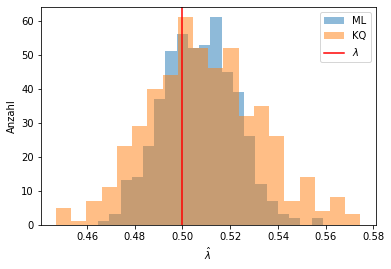

In [22]:
plt.hist(lst_est_ml, bins=20, alpha=0.5, label="ML")
plt.hist(lst_est_kq, bins=20, alpha=0.5, label="KQ")
plt.axvline(0.5, 0, 1, c='r', label=r'$\lambda$')
plt.xlabel("$\hat{\lambda}$")
plt.ylabel("Anzahl")
plt.legend(loc='upper right')
plt.show()

Berechnen und vergleichen Sie nun die Mittelwerte und die Standardabweichungen der beiden Listen, die Sie erzeugt haben. Was stellen Sie fest im Vergleich der beiden Methoden? Welches ist die genaueste Methode (kleinster Bias), welches die präziseste (kleinster Fehler)? 

In [23]:
print("ML:",np.mean(lst_est_ml),"+/-",np.std(lst_est_ml))
print("KQ:",np.mean(lst_est_kq),"+/-",np.std(lst_est_kq))

ML: 0.5069447326556108 +/- 0.015144338759129272
KQ: 0.5089298334070115 +/- 0.02320347247311683


In [24]:
print('success rate')
print(f"ML: {len(lst_est_ml)/n}")
print(f"KQ: {len(lst_est_kq)/n}")

success rate
ML: 1.0
KQ: 1.0
